In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append("/codespace/localizing-edm/")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
import json
import torch
import dnnlib
import pickle
import pandas as pd
import numpy as np

from scorer import VEScorer, plot_score_grid
from flows import ScoreFlow, PatchFlow
from torch.nn.functional import interpolate

root = '/codespace//localizing-edm/workdir/runs'
model_file = f"{root}/finetune_cifar/cable/00009-mvtec_cable_128-uncond-ncsnpp-ve-gpus1-batch48-fp32/network-snapshot-004000.pkl"
device = torch.device('cuda')

with dnnlib.util.open_url(model_file) as f:
    model = pickle.load(f)
    net = model["ema"]
model.keys()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['ema', 'loss_fn', 'augment_pipe', 'dataset_kwargs'])

In [26]:
model_root = "/".join(model_file.split("/")[:-1])
model_root

'/codespace//localizing-edm/workdir/runs/finetune_cifar/cable/00009-mvtec_cable_128-uncond-ncsnpp-ve-gpus1-batch48-fp32'

In [4]:
with open(f"{model_root}/stats.jsonl", "r") as f:
    stats = pd.read_json(path_or_buf=f, lines=True)

# Extraact the nested object from the first line
nested_object = stats['Loss/loss']

# Convert the nested object to a DataFrame
df = pd.DataFrame.from_records(nested_object)

# Display the DataFrame
print(df)

           num      mean       std
0      2359296  0.071408  0.249461
1     49545216  0.069414  0.257982
2     49545216  0.068778  0.250920
3     49545216  0.069692  0.257079
4     49545216  0.068840  0.253257
...        ...       ...       ...
2973  49545216  0.061837  0.233738
2974  49545216  0.063461  0.234149
2975  49545216  0.063154  0.232519
2976  49545216  0.062809  0.232941
2977   7077888  0.060370  0.231798

[2978 rows x 3 columns]


<AxesSubplot: >

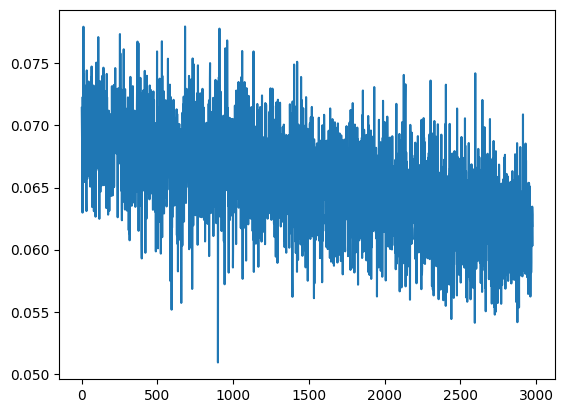

In [5]:
df['mean'].plot()

In [6]:
net.init_kwargs

{'model_type': 'SongUNet',
 'embedding_type': 'fourier',
 'encoder_type': 'residual',
 'decoder_type': 'standard',
 'channel_mult_noise': 2,
 'resample_filter': [1, 3, 3, 1],
 'model_channels': 128,
 'channel_mult': (1, 2, 2, 2),
 'augment_dim': 15,
 'dropout': 0.1,
 'use_fp16': False,
 'num_blocks': 4,
 'img_resolution': 32,
 'img_channels': 3,
 'label_dim': 0}

In [7]:
augment_pipe = model["augment_pipe"]
augment_pipe.init_kwargs

{'p': 0.08,
 'xflip': 100000000.0,
 'yflip': 1,
 'scale': 1,
 'rotate_frac': 1,
 'aniso': 1,
 'translate_frac': 1,
 'brightness': 1,
 'contrast': 1,
 'lumaflip': 1,
 'hue': 1,
 'saturation': 1}

In [8]:
model["dataset_kwargs"]

{'class_name': 'training.dataset.MVTecDataset',
 'path': '/DATA/Users/amahmood/GDrive/MVTec_AD/cable',
 'use_labels': False,
 'xflip': False,
 'cache': True,
 'resolution': 128,
 'max_size': 224}

In [9]:
res =  model["dataset_kwargs"]["resolution"]

In [10]:
flow_path = "/codespace/localizing-edm/workdir/runs/cifar-base/cable/patch-only/"
config = pd.read_json(f"{flow_path}/config.json")
num_sigmas = config.config.loc['num_sigmas']
levels = config.config.loc['levels']
num_blocks = config.config.loc['num_blocks']
use_fp16 = config.config.loc['fp16']
min_sigma = config.config['sigma_min']

In [11]:
from flows import PatchFlow

conv_inn = PatchFlow((num_sigmas, res, res), num_blocks=num_blocks, patch_size=7,
                     global_flow=False, spatial_cond_dim=128)
flownet = ScoreFlow(conv_inn, net, num_sigmas=num_sigmas, use_fp16=False, sigma_min=min_sigma,
                    vectorize=False).to(device)
state_dict = torch.load(f"{flow_path}/checkpoint-meta.pth", map_location=torch.device('cpu'))
flownet.load_state_dict(state_dict["model_state_dict"], strict=True,  )
print("Loaded", state_dict['kimg'],state_dict['val_loss'])

Generating 7x7 patches from input size: (20, 128, 128)
Pooled spatial resolution: (32, 32)
Number of flows / patches: 1024
Loaded 780 -22745.118750095367


In [12]:
from training.dataset import MVTecDataset

mvtec_ds = MVTecDataset(path=model["dataset_kwargs"]['path'],
                        train=False, resolution=128)
inlier_samples, _ = mvtec_ds.load_test(only_normal=True)
ood_samples, masks = mvtec_ds.load_test(skip_normal=True)
inlier_samples = torch.stack(inlier_samples) / 127.5 - 1
ood_samples = torch.stack(ood_samples) / 127.5 - 1
masks = torch.stack(masks)
inlier_samples.shape, ood_samples.shape, ood_samples.dtype 

(torch.Size([58, 3, 128, 128]), torch.Size([92, 3, 128, 128]), torch.float32)

<AxesSubplot: >

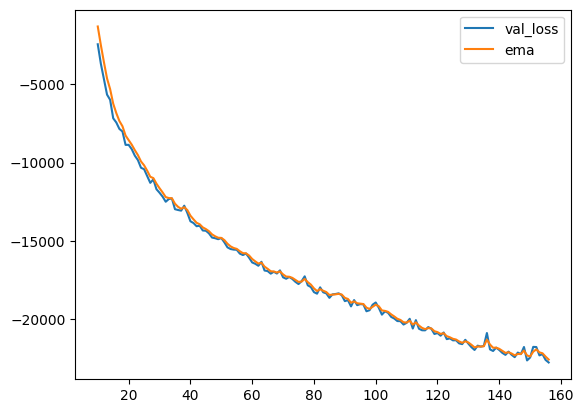

In [13]:
df = pd.read_csv(f"{flow_path}/losses.csv")
df[10:].plot()

In [14]:
# summary(flownet.flow, input_size=(1,num_sigmas, res, res), verbose=0)

In [15]:
ood_batch = ood_samples[:16].cuda()
inlier_batch = inlier_samples[:16].cuda()

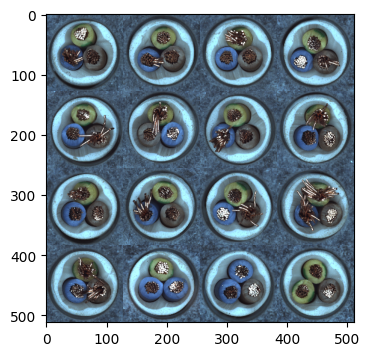

In [16]:
from scorer import build_img_grid
rows = 4
plt.subplots(1,1,figsize=(rows,rows))
plt.imshow(build_img_grid((ood_batch.cpu()+1)*0.5,rows=rows))

In [17]:
%%time

scores = flownet.scorenet(ood_batch).cpu()
scores.shape

CPU times: user 6.23 s, sys: 6.76 s, total: 13 s
Wall time: 13 s


torch.Size([16, 20, 128, 128])

In [18]:
%%time
ano_score = flownet.score_patches(ood_batch[:4]).cpu()

CPU times: user 2.75 s, sys: 1.75 s, total: 4.49 s
Wall time: 4.5 s


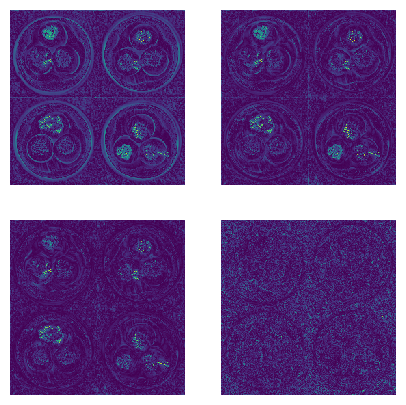

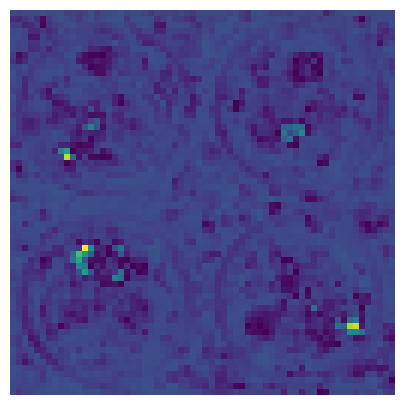

In [19]:
plot_score_grid(scores, num_samples=4, plot_sigma_idxs = [1, 7, 11, 19])
plot_score_grid(ano_score.unsqueeze(1), num_samples=4, plot_sigma_idxs = [0])

In [20]:
%%time
ood_logpx = []
for x_ood_batch in ood_samples.chunk(5):
    ood_logpx.append(flownet.score_patches(x_ood_batch.cuda()).cpu())
ood_logpx = torch.cat(ood_logpx).cpu()
ood_logpx.shape

CPU times: user 35.1 s, sys: 41.5 s, total: 1min 16s
Wall time: 1min 16s


torch.Size([92, 32, 32])

In [21]:
%%time
inlier_logpx = []
for x_batch in inlier_samples.chunk(5):
    inlier_logpx.append(flownet.score_patches(x_batch.cuda()).cpu())
inlier_logpx = torch.cat(inlier_logpx)

CPU times: user 24.2 s, sys: 25.8 s, total: 50 s
Wall time: 50.1 s


In [22]:
expected_ano_score = inlier_logpx.mean().item()
# expected_ano_score = inlier_logpx.quantile(0.9).item()
expected_ano_score

21.524267196655273

In [23]:
from flow_utils import plot_batch_with_heatmaps

# assuming images_batch and anomaly_maps are your data
def upsample(x, size=128):
    if x.dim() == 3:
        x = x.unsqueeze(1)
    return interpolate(x, size=size, mode="bilinear",
                align_corners=False).cpu().squeeze(1).numpy()

batch_size = 9
torch.manual_seed(42)
rand_idxs = torch.randperm(ood_logpx.shape[0])[:batch_size]
images_batch = ood_samples[rand_idxs].cpu()
heatmap = upsample(ood_logpx[rand_idxs])
inlier_images_batch = inlier_batch.cpu()
inlier_heatmap = upsample(inlier_logpx)

In [24]:
images_batch.shape, heatmap.shape

(torch.Size([9, 3, 128, 128]), (9, 128, 128))

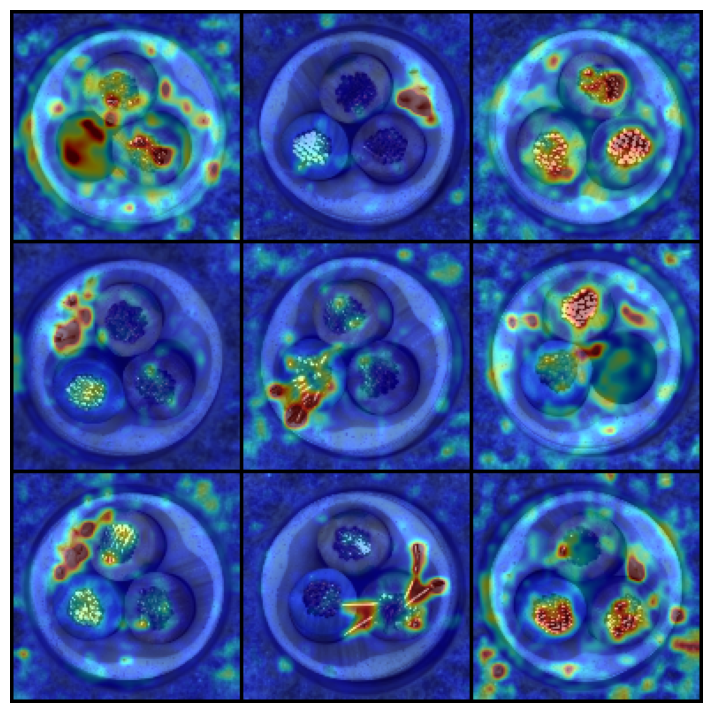

In [27]:
# define grid size and alpha for heatmap opacity
grid_size = (3, 3)
alpha = 0.4

# Call the function with the RGB image batch and the anomaly maps batch
ano = plot_batch_with_heatmaps(images_batch, -heatmap, clip_val=None, blur_radius=3,
                               grid_size=grid_size, alpha=alpha, linthresh_q=0.99)

In [29]:
from flow_utils import metrics_evaluation
downsampled_masks = interpolate(masks, scale_factor=0.5, mode="nearest").cpu().squeeze(1).numpy()
ood_heatmaps = -1 * upsample(ood_logpx, size=512)
inlier_heatmaps = -1 * interpolate(inlier_logpx.unsqueeze(1).cpu(),scale_factor=16,
                                    mode="bilinear", align_corners=True).squeeze(1).numpy()

anomaly_heatmaps = np.concatenate((ood_heatmaps, inlier_heatmaps))
seg_masks = np.concatenate((downsampled_masks, np.zeros_like(inlier_heatmaps)))
seg_masks.shape, anomaly_heatmaps.shape, ood_samples.shape

((150, 512, 512), (150, 512, 512), torch.Size([92, 3, 128, 128]))

In [30]:
downsampled_masks.shape

(92, 512, 512)

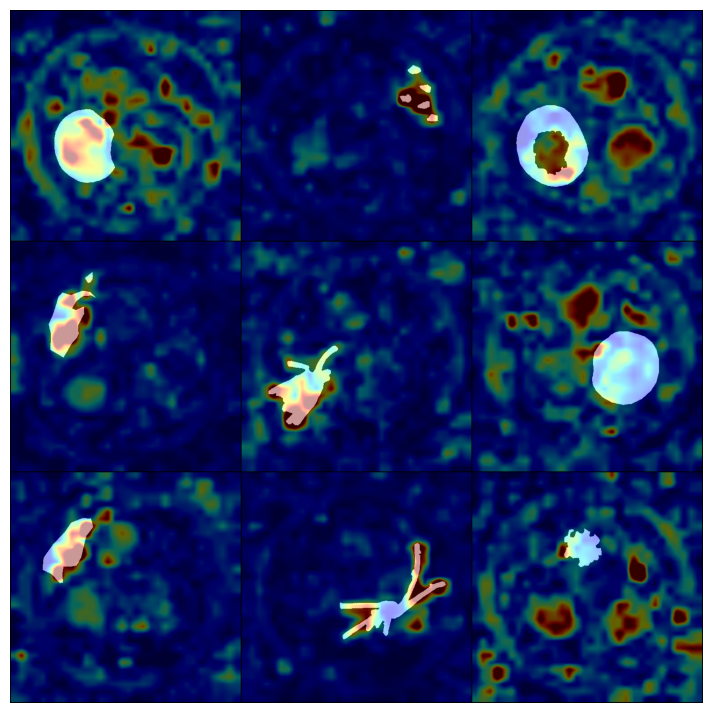

In [33]:
im=downsampled_masks[rand_idxs, None,...].repeat(3,axis=1) / 255
_ = plot_batch_with_heatmaps(torch.from_numpy(im), ood_heatmaps[rand_idxs], clip_val=None,
                            grid_size=(3,3), alpha=0.6, linthresh_q=0.99, blur_radius=5)

In [ ]:
%%time
df, df_fpr = metrics_evaluation(anomaly_heatmaps, seg_masks, max_step=1000)

In [35]:
scores.shape

torch.Size([16, 20, 128, 128])

In [39]:
patch_score_norms = flownet.flow.patchify(flownet.flow.local_pooler(scores.cuda()))
patch_score_norms.shape

torch.Size([1024, 16, 20])

In [52]:
!nvidia-smi

Wed Jun 28 14:23:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:43:00.0 Off |                  Off |
| 30%   36C    P8              28W / 300W |     24MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [44]:
q = patch_score_norms[:1].clone()
k = patch_score_norms.clone()
v = patch_score_norms.clone()

In [90]:
attention = torch.nn.MultiheadAttention(20, num_heads=4, device="cuda")
summary(attention, input_data=(k,k,k), verbose=2)
attention

Layer (type:depth-idx)                   Output Shape              Param #
MultiheadAttention                       [1024, 16, 20]            1,680
├─in_proj_weight                                                   ├─1,200
├─in_proj_bias                                                     └─60
Total params: 1,680
Trainable params: 1,680
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 3.93
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 3.93


MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
)

In [94]:
%%time
x, attn = attention(v,v,v)

CPU times: user 278 µs, sys: 987 µs, total: 1.26 ms
Wall time: 910 µs


In [95]:
%%time
x, attn = attention(q,k,v)

CPU times: user 602 µs, sys: 890 µs, total: 1.49 ms
Wall time: 1.03 ms


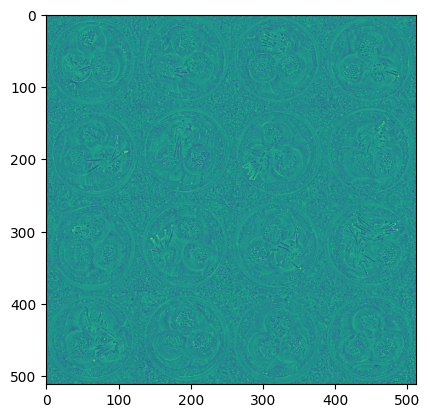

In [98]:
x = x.cpu().detach()
attn = attn.cpu().detach()
attn_im = attn.reshape(4,4,32,32).permute(0,2,1,3).reshape(32*4,32*4)
im = scores.mean(dim=1).reshape(4,4,128,128).permute(0,2,1,3).reshape(128*4,128*4)
plt.imshow(im)

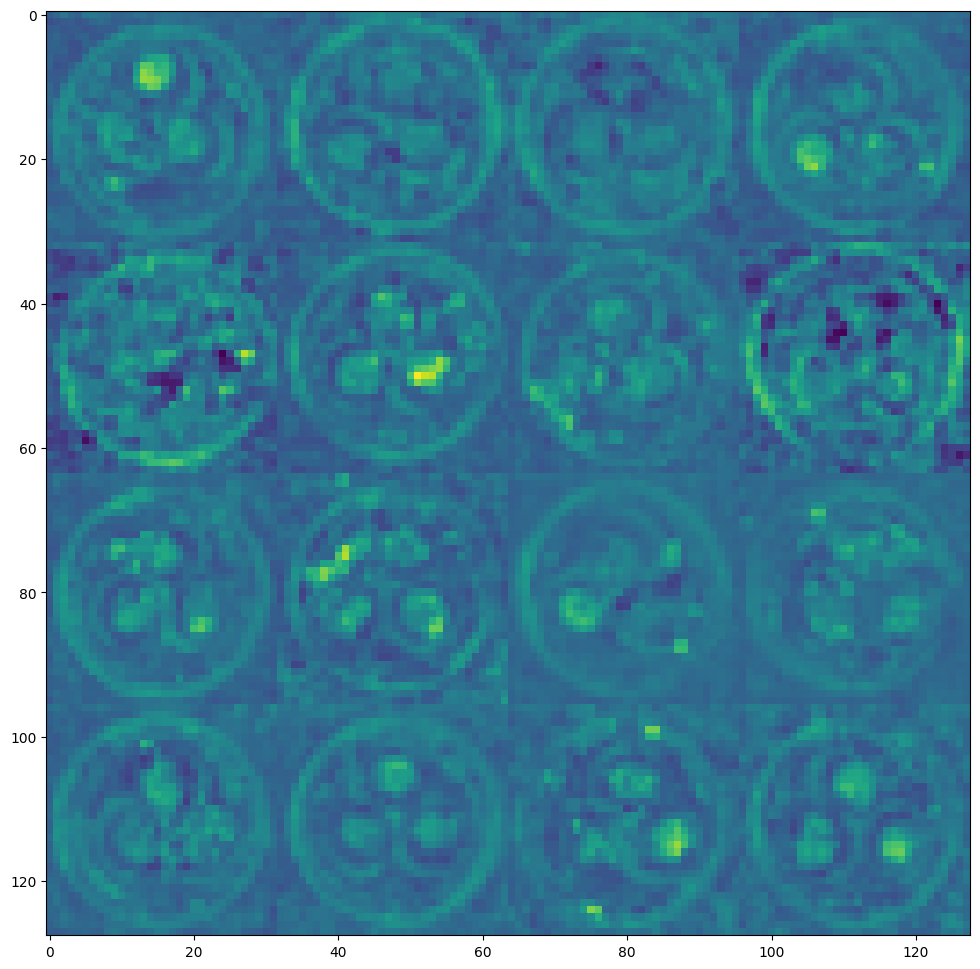

In [99]:
plt.subplots(1,1,figsize=(12,12))
plt.imshow(attn_im,)

In [104]:
patch_score_norms.shape, flownet.flow.positional_encoding.shape

(torch.Size([1024, 16, 20]), torch.Size([1024, 128]))

In [226]:
w = torch.randn(20, 128).cuda()
Q = patch_score_norms @ w #* 0.01
Q *= flownet.flow.positional_encoding.unsqueeze(1)
Q.shape

torch.Size([1024, 16, 128])

In [257]:
attention = torch.nn.MultiheadAttention(128, num_heads=4, device="cuda", batch_first=False)
summary(attention, verbose=2)
attention

Layer (type:depth-idx)                        Param #
MultiheadAttention                            49,536
├─in_proj_weight                              ├─49,152
├─in_proj_bias                                └─384
├─NonDynamicallyQuantizableLinear: 1-1        16,512
│    └─weight                                 ├─16,384
│    └─bias                                   └─128
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0


MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
)

In [312]:
transformer = torch.nn.TransformerEncoderLayer(128, nhead=4, device="cuda", batch_first=False)
summary(transformer, input_data=Q, verbose=2)
transformer

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1024, 16, 128]           --
├─MultiheadAttention: 1-1                [1024, 16, 128]           66,048
│    └─in_proj_weight                                              ├─49,152
│    └─in_proj_bias                                                ├─384
│    └─out_proj.weight                                             ├─16,384
│    └─out_proj.bias                                               └─128
├─Dropout: 1-2                           [1024, 16, 128]           --
├─LayerNorm: 1-3                         [1024, 16, 128]           256
│    └─weight                                                      ├─128
│    └─bias                                                        └─128
├─Linear: 1-4                            [1024, 16, 2048]          264,192
│    └─weight                                                      ├─262,144
│    └─bias                                 

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (linear1): Linear(in_features=128, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

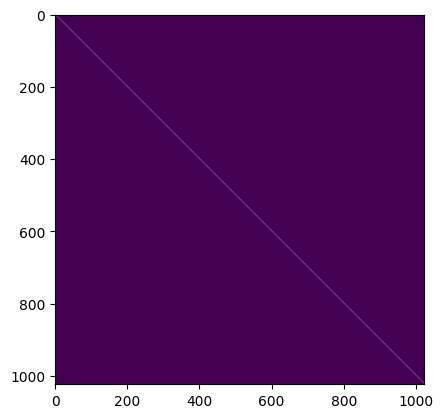

In [309]:
# Mask implies NOT attending
mask = torch.eye(1024).bool().cuda()
plt.imshow(mask.cpu())

In [300]:
%%time
x, attn = attention(Q,Q,Q, attn_mask=mask)
x.shape, attn.shape

CPU times: user 1.04 ms, sys: 12 µs, total: 1.05 ms
Wall time: 1.08 ms


(torch.Size([1024, 16, 128]), torch.Size([16, 1024, 1024]))

In [311]:
%%time
x = transformer(Q, src_mask=mask)
x.shape

CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 1.73 ms


torch.Size([1024, 16, 128])

In [492]:
transformer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (linear1): Linear(in_features=128, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [475]:
import torch.nn as nn


class ScoreAttentionBlock(nn.Module):
    def __init__(self, num_sigmas, embed_dim, num_heads=4):
        super().__init__()
        self.proj = nn.Parameter(torch.randn(num_sigmas, embed_dim))
        self.norm = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.pos_enc = flownet.flow.positional_encoding.unsqueeze(0)
        
    def forward(self, x, attn_mask=None, post_norm=False):
        
        # Making batch first to trigger flash attention
        x = x.permute(1,0,2)
        assert x.shape[1] == self.pos_enc.shape[1], "Can only be called on flattened image"
        
        x = x @ self.proj
        print(x.mean(), self.pos_enc.mean())
        print("After enc:",(x + self.pos_enc).mean())
        if post_norm:
            x = self.norm(x.add_(self.pos_enc))
        else:
            x = x.add_(self.pos_enc)
#             x = x#self.norm(x).add_(self.pos_enc)
        
        print("After norm:",x.mean())
        
        x, attn = self.attention(x,x,x, attn_mask=attn_mask,)
        x = x.permute(1,0,2)
        return x, attn

In [476]:
attention_block = ScoreAttentionBlock(num_sigmas=20, embed_dim=128).cuda()

In [491]:
pos.unsqueeze(0).shape, pos.unsqueeze(0)[:, [3], :].shape

(torch.Size([1, 1024, 20]), torch.Size([1, 1, 20]))

In [477]:
patch_score_norms.shape

torch.Size([1024, 16, 20])

In [478]:
%%time
x_pre, prenorm_attn = attention_block(patch_score_norms, mask, post_norm=False)
x_post, postnorm_attn = attention_block(patch_score_norms, mask, post_norm=True)

tensor(0.5479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.4106, device='cuda:0')
After enc: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
After norm: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5479, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.4106, device='cuda:0')
After enc: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
After norm: tensor(1.9354e-09, device='cuda:0', grad_fn=<MeanBackward0>)
CPU times: user 9.89 ms, sys: 1.99 ms, total: 11.9 ms
Wall time: 12 ms


In [479]:
x = x.cpu().detach()
attn = attn.cpu().detach()
attn_im = attn.reshape(4,4,attn.shape[-1],attn.shape[-2]).permute(0,2,1,3).reshape(attn.shape[-2]*4,attn.shape[-1]*4)

In [480]:
x_pre = x_pre.cpu().detach()
preattn = prenorm_attn.cpu().detach()
pre_attn_im = preattn.reshape(4,4,attn.shape[-1],attn.shape[-2]).permute(0,2,1,3).reshape(attn.shape[-2]*4,attn.shape[-1]*4)

x_post = x_post.cpu().detach()
postattn = postnorm_attn.cpu().detach()
post_attn_im = postattn.reshape(4,4,attn.shape[-1],attn.shape[-2]).permute(0,2,1,3).reshape(attn.shape[-2]*4,attn.shape[-1]*4)

In [481]:
postnorm_attn.shape

torch.Size([16, 1024, 1024])

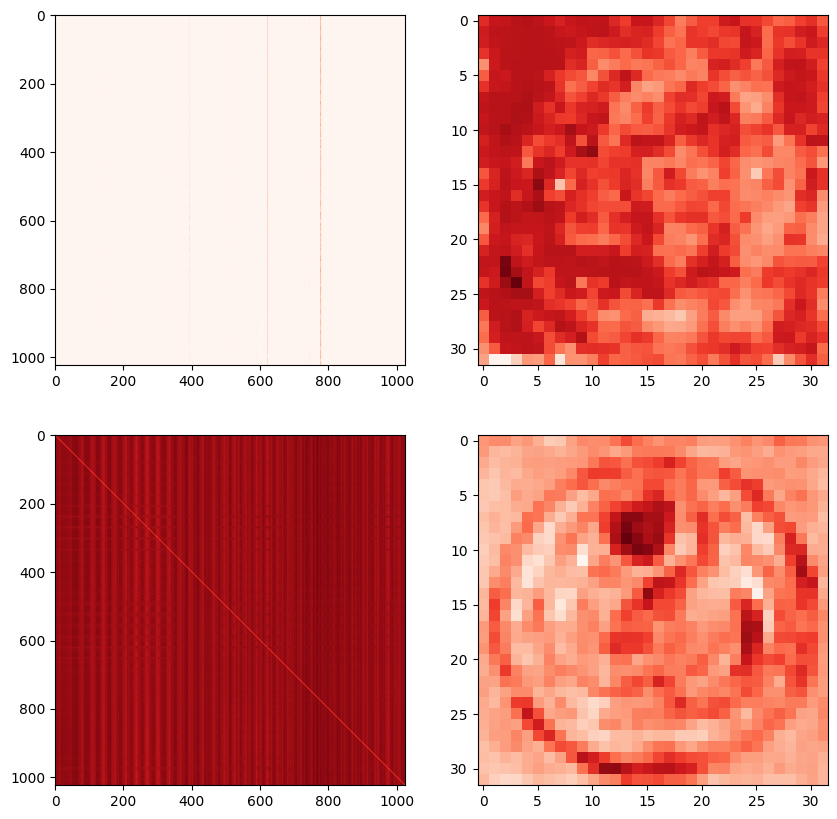

In [482]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
axs[0].imshow(preattn[0], cmap="Reds")
axs[1].imshow(x_pre[:,0].sum(-1).reshape(32,32), cmap="Reds")

axs[2].imshow(postattn[0], cmap="Reds")
axs[3].imshow(x_post[:,0].sum(-1).reshape(32,32), cmap="Reds")

In [483]:
postattn.shape

torch.Size([16, 1024, 1024])

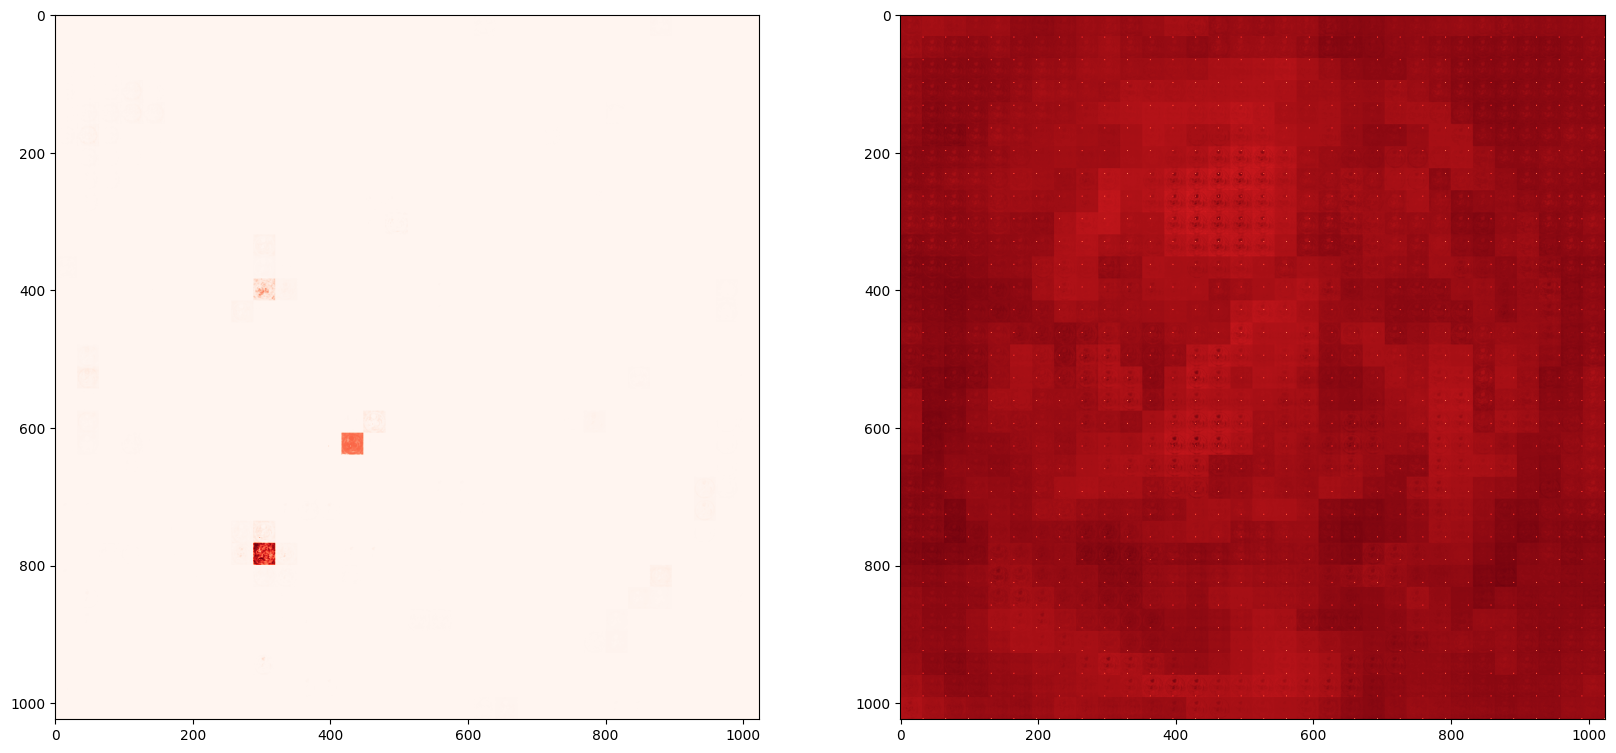

In [484]:
#Attention map for each pixel
per_pix_attn = preattn[0]
per_pix_attn = per_pix_attn.permute(1,0).reshape(32,32,32,32).permute(0,2,1,3).reshape(1024,1024)
fig,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].imshow(per_pix_attn, cmap="Reds")

#Attention map for each pixel
per_pix_attn = postattn[0]
per_pix_attn = per_pix_attn.permute(1,0).reshape(32,32,32,32).permute(0,2,1,3).reshape(1024,1024)
axs[1].imshow(per_pix_attn, cmap="Reds")

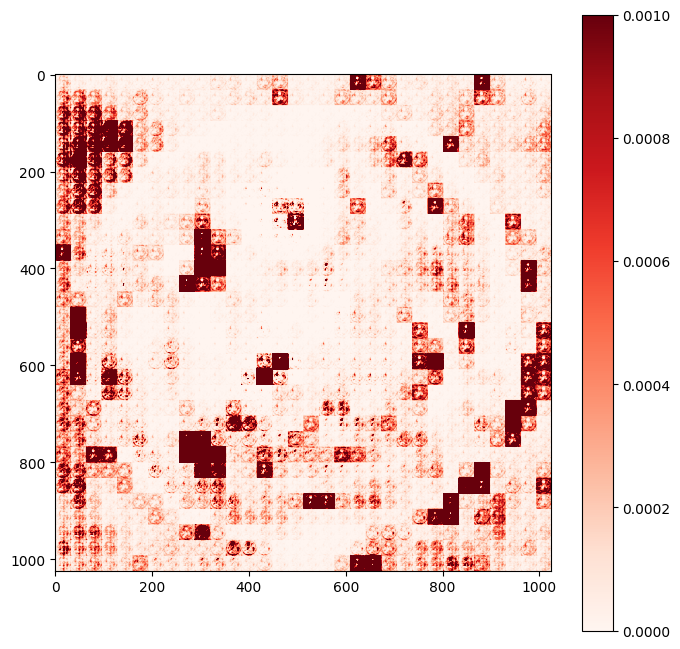

In [486]:
#Attention map for each pixel
per_pix_attn = preattn[0]
per_pix_attn = per_pix_attn.permute(1,0).reshape(32,32,32,32).permute(0,2,1,3).reshape(1024,1024)
plt.subplots(1,1,figsize=(8,8))
plt.imshow(per_pix_attn, vmax=0.001, cmap="Reds")
plt.colorbar()

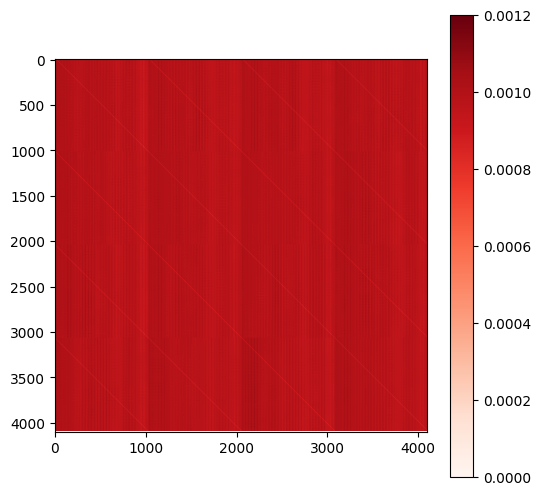

In [441]:
plt.subplots(1,1,figsize=(6,6))
plt.imshow(pre_attn_im, cmap="Reds")
plt.colorbar()

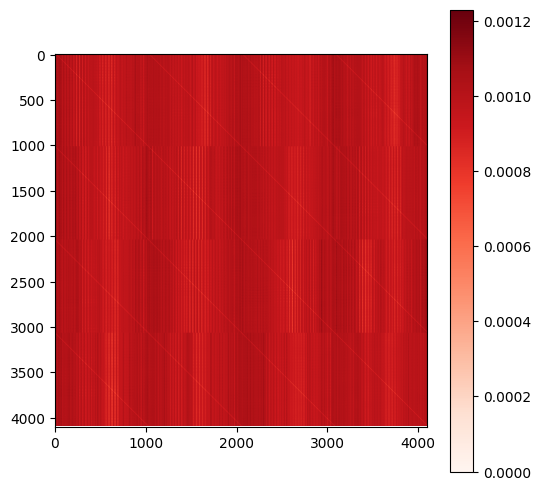

In [444]:
plt.subplots(1,1,figsize=(6,6))
plt.imshow(post_attn_im, cmap="Reds")
plt.colorbar()

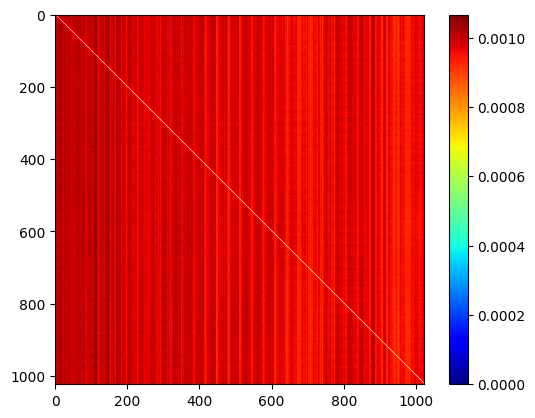

In [442]:
plt.imshow(attn.mean(0), cmap="jet")
plt.colorbar()

In [159]:
Q.shape

torch.Size([1024, 16, 128])

In [200]:
pos = flownet.flow.positional_encoding[:, 0:100:5]
cos = torch.stack([torch.cosine_similarity(x,pos) for x in pos])
cos = cos.cpu().detach()
cos.shape

torch.Size([1024, 1024])

In [201]:
pos.shape

torch.Size([1024, 20])

In [416]:
Q = patch_score_norms[:,0,:]
Q = (Q-Q.mean(dim=-1, keepdim=True))/Q.std(dim=-1, keepdim=True)# + pos
Qcos = torch.stack([torch.cosine_similarity(x,Q) for x in Q])
Qcos = Qcos.cpu().detach()

Q = patch_score_norms[:,0,:] + pos
# Q = (Q-Q.mean(dim=-1, keepdim=True))/Q.std(dim=-1, keepdim=True)
Qposcos = torch.stack([torch.cosine_similarity(x,Q) for x in Q])
Qposcos = Qposcos.cpu().detach()

# Layer norming the scores first may lessen the positio
Q = patch_score_norms[:,0,:] + pos
Qnorm = (Q-Q.mean(dim=-1, keepdim=True))/Q.std(dim=-1, keepdim=True)# + pos
Qnormcos = torch.stack([torch.cosine_similarity(x,Qnorm) for x in Qnorm])
Qnormcos = Qnormcos.cpu().detach()
Qposcos.shape

torch.Size([1024, 1024])

In [421]:
pos.shape

torch.Size([1024, 20])

<AxesSubplot: >

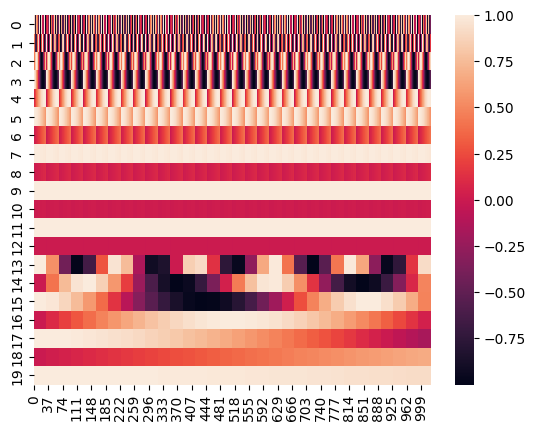

In [420]:
sns.heatmap(pos.cpu().T)

<AxesSubplot: >

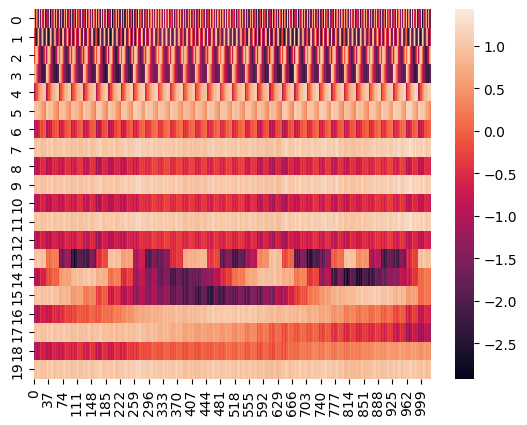

In [423]:
sns.heatmap(((pos-pos.mean(dim=-1, keepdim=True))/pos.std(dim=-1, keepdim=True)).cpu().T)

<AxesSubplot: >

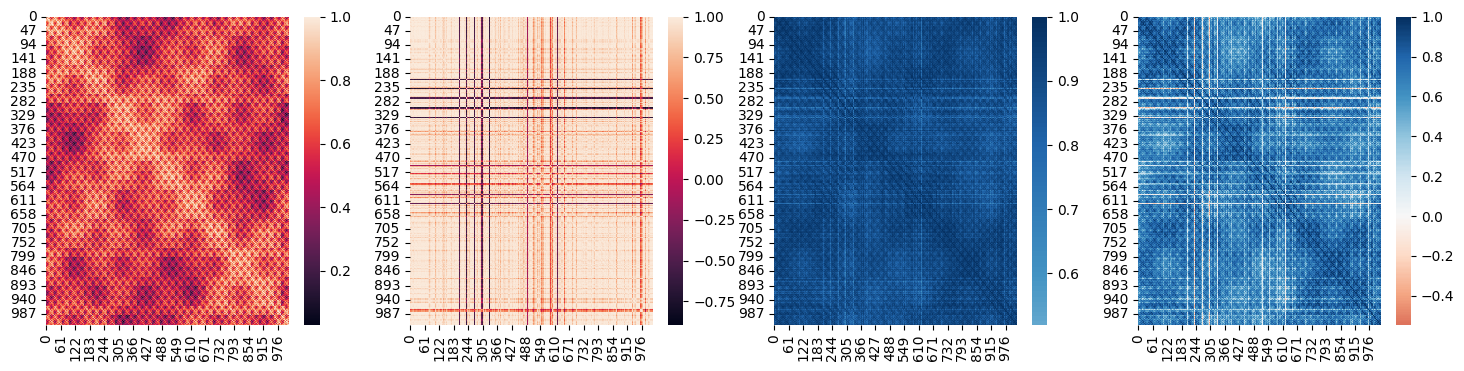

In [417]:
import seaborn as sns
fig,axs = plt.subplots(1,4, figsize=(18,4))
sns.heatmap(cos, ax=axs[0])
sns.heatmap(Qcos, ax=axs[1])
sns.heatmap(Qposcos, ax=axs[2], center=0,cmap="RdBu")
sns.heatmap(Qnormcos, ax=axs[3], center=0,cmap="RdBu")

In [ ]:
conv = torch.nn.Conv2d(1,1,16,stride=4, padding=4)
conv(torch.empty(1,1,32,32)).shape

In [ ]:
plt.plot(df.fpr, df.pros_mean)
plt.plot(df_fpr.fpr, df_fpr.pros_mean)